# Legend:
# Header
## Secondary Header (Give more info)
    /#/ comment on what the give code is doing
    Markdown no # My comments to help understand how to use the data
#### Step by step analysis

# Step 1: Import and sort the data by data type and data category

In [1]:
#H0 Hypothesis: Given features, the person will get a loan

import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy import stats
%matplotlib inline

df = pd.read_csv("../Loan Prediction/data_python.csv")

test = pd.read_csv('train.csv')

    Type of Variable
        Predictor Variables:
                Gender, Married, Dependents, Education, Self employed, Applicant income, Coapplicant Income, Loan Amount, Loan Amount Term, Credit History, Property area
        Target Variable:
            Loan Status

    Data Types
        Character:
            Loan ID, Gender, Married, Dependents, Education, Self Employed, Property Area, Loan Status, Credit History
        Nunmeric:
            Dependents, Applicant Income, Coapplicant Income, Loan Amount, Loan Amount Term

    Variable Category
        Categorical:
            Gender, Married, Education, Self Employed, Property Area, Loan Status, Dependents
        Continuous:
            Credit History, Applicant Income, Coapplicant Income, Loan Amount, Loan Amount Term

In [2]:
print(df.head(6))

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   
5  LP001011   Male     Yes          2      Graduate           Yes   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   

   Credit_History 

# Step 2: Raw Data Analysis

## Step 2.1: Understanding the various features (columns) of the dataset by visualizing the data and finding extreme values

In [3]:
#Summary of Numeric Variables for Training Data Set

df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


#### For the non-numerical values/Character Values, we can look at frequency distribution to understand whether they make sense or not.
    

In [4]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

print ("Frequency Table For Credit History")
print (temp1)
print ('\nProbablitity of getting a loan for each Credit History class\n')
print (temp2)

Frequency Table For Credit History
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probablitity of getting a loan for each Credit History class

                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


## Step 2.2: Understanding Distribution of Numerical Variables: Applicant income & Loan amount

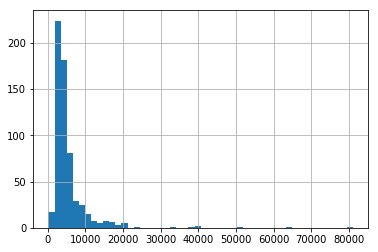

In [5]:
#Box Plot for understanding distributions and to observe the outliers
#Histogram of variable Applicant Income

df['ApplicantIncome'].hist(bins=50)

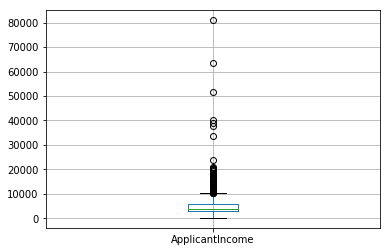

In [6]:
#Box plot for variable ApplicantIncome of training data set

df.boxplot(column='ApplicantIncome')

#### The above Box Plot confirms the presence of outliers/extreme values. This can be attributed to the income disparity in society.

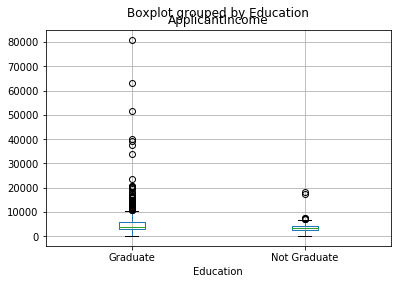

In [7]:
#Box plot for variable ApplicantIncome by variable Education of data training set

df.boxplot(column='ApplicantIncome', by='Education')

#### We can see that there is no substatial difference between the mean income of graduates versus non gradutates. There are, however, a higher number of graduates with much high incomes, which are appearing to be the outliers.

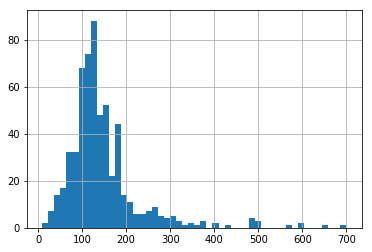

In [8]:
#Histogram of variable LoanAmount

df['LoanAmount'].hist(bins=50)

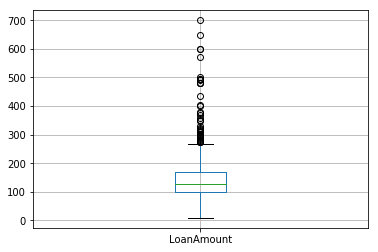

In [9]:
#Box plot for variable LoanAmount of training data set

df.boxplot(column='LoanAmount')

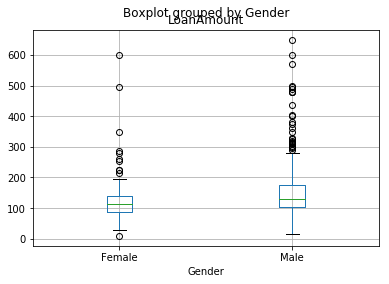

In [10]:
#Box plot for variable LoanAmount by variable Gender of training data set

df.boxplot(column='LoanAmount', by='Gender')

In [11]:
#Find out how many categories have null values

df.apply(lambda x: sum(x.isnull()),axis=0)
#or df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Depending on the data sample size, if a certain category has few missing values, it may be easier just to remove those data points, but if too small, replace the null with the mean of the rest of the category

#### Loan Amount has missing and extreme values, while Applicant Income has few extreme values.

## Other data values

In [12]:
#Get the unique values and their frequency for variable Property_Area

df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

## Step 2.3 understanding distributions of variables

In [13]:
# loan approval rates in absolute numbers
loan_approval = df['Loan_Status'].value_counts()['Y']
print(loan_approval)

422


#### 422 number of loans were approved

In [14]:
#Credit History and Loan Status

pd.crosstab(df['Credit_History'], df['Loan_Status'], margins=True)

Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


In [15]:
#Function to output percentage row wise in a cross table
def percentageConvert(ser):
    return ser/float(ser[-1])

#Loan Approval rate for customers having Credit History (1)
pdf = pd.crosstab(df ['Credit_History'], df ['Loan_Status'], margins=True).apply(percentageConvert, axis=1)
loan_approval_with_Credit_1 = pdf['Y'][1]
print(loan_approval_with_Credit_1*100)

79.57894736842105


#### 79.57% of Applicants whose loans were approved have Credit_History equals to 1

In [16]:
pdf['Y']

Credit_History
0.0    0.078652
1.0    0.795789
All    0.682624
Name: Y, dtype: float64

In [17]:
# Replace missing value of Self_Employed with more frequent category
df['Self_Employed'].fillna('No',inplace=True)

## Step 2.4: Finding outliers of LoanAmount and ApplicantIncome

In [18]:
#Add both ApplicantIncome and CoapplicantIncome to TotalIncome

df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

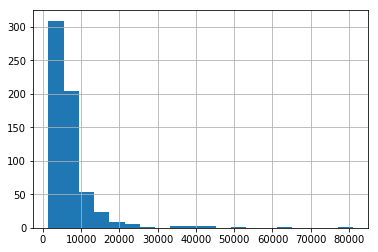

In [19]:
#Looking at the distribution of TotalIncome

df['TotalIncome'].hist(bins=20)

    The extreme values are practically possible, i.e. someone might apply for high value loans due to specific needs. So instead of treating them as outliers, let's try a log transformation to nullify their effect

## Step 2.5 Preform log transformation of Total income to make it closer to normal


In [20]:
df["LoanAmount_Log"] = np.log(df['LoanAmount'])

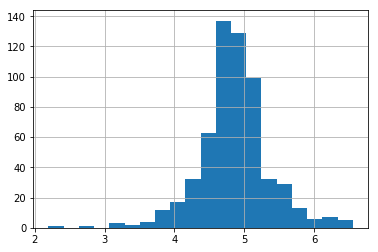

In [21]:
#Looking at distribution of TotalIncome_Log
df['LoanAmount_Log'].hist(bins=20)

# Step 3: Data Preparation for Model Building

    sklearn requires all inputs to be numeric, we should convert all our categorical variables into numeric by encoding the catefories. Before that we will fill in all the missing values in the dataset.

In [22]:
# Impute missing values for Gender
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

#Impute missing values
df['Married'].fillna(df['Married'].mode()[0], inplace=True)

#Impute missing values
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)

#Impute missing values
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

#Convert all non-numeric values to a number
cat = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

for var in cat:
    le = sklearn.preprocessing.LabelEncoder()
    df[var]=le.fit_transform(df[var].astype('str'))
df.dtypes

Loan_ID               object
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History         int32
Property_Area          int32
Loan_Status           object
TotalIncome          float64
LoanAmount_Log       float64
dtype: object

# Step 4: Generic Classification Function

In [39]:
# Import models from scikit learn module:
from sklearn import metrics

#Generic function for making a classification model and accessing performance:

def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors], data[outcome])
    
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
    
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ('Accuracy : %s' % '{0:.3%}'.format(accuracy))
    
    #Preform k-fold cross validation with 5 folds
    kf = sklearn.model_selection.KFold(n_splits=5)
    error = []
    for train, test in kf.split(x_train):
        #Filter training data
        train_predictors = (data[predictors].iloc[train,:])
        
        #The target we're using to train the algorithm
        train_target = data[outcome].iloc[train]
        
        #Training the algorithm using the predictors and target
        model.fit(train_predictors, train_target)
        
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
        print ('Cross-Validation Score: %s' % '{0:.3%}'.format(np.mean(error)))
    #Fit the model again so that it can be referred outside the function:
    model.fit(data[predictors],data[outcome])

# Step 5: Model Building

In [40]:
#Combining both train and test dataset

#Create a flag for Train and Test Data set
df['Type']='Train'
test['Type']='Test'
fullData = pd.concat([df, test], axis=0, sort=True)

#Look at the available missing values in the dataset
fullData.isnull().sum()

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        50
Dependents            15
Education              0
Gender                13
LoanAmount            44
LoanAmount_Log       636
Loan_Amount_Term      28
Loan_ID                0
Loan_Status            0
Married                3
Property_Area          0
Self_Employed         32
TotalIncome          614
Type                   0
dtype: int64

In [41]:
#Identify categorical and continuous variables

ID_col = ['Loan_ID']
target_col = ['Loan_Status']
cat_cols = ['Credit_History', 'Dependents', 'Gender', 'Married', 'Education', 'Property_Area', 'Self_Employed']

In [42]:
#Imputing missing values with mean for continuous variable
fullData['LoanAmount'].fillna(fullData['LoanAmount'].mean(), inplace=True)
fullData['LoanAmount_Log'].fillna(fullData['LoanAmount_Log'].mean(), inplace=True)
fullData['Loan_Amount_Term'].fillna(fullData['Loan_Amount_Term'].mean(), inplace=True)
fullData['ApplicantIncome'].fillna(fullData['ApplicantIncome'].mean(), inplace=True)
fullData['CoapplicantIncome'].fillna(fullData['CoapplicantIncome'].mean(), inplace=True)

#Imputing missing values with mode for the categorical variables
fullData['Gender'].fillna(fullData['Gender'].mode()[0], inplace=True)
fullData['Married'].fillna(fullData['Married'].mode()[0], inplace=True)
fullData['Dependents'].fillna(fullData['Dependents'].mode()[0], inplace=True)
fullData['Loan_Amount_Term'].fillna(fullData['Loan_Amount_Term'].mode()[0], inplace=True)
fullData['Credit_History'].fillna(fullData['Credit_History'].mode()[0], inplace=True)

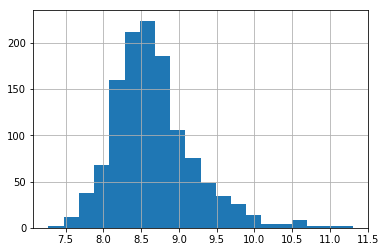

In [43]:
#Create a new column as Total Income

fullData['TotalIncome']=fullData['ApplicantIncome'] + fullData['CoapplicantIncome']

fullData['TotalIncome_log']=np.log(fullData['TotalIncome'])

#Histogram for Total Income
fullData['TotalIncome_log'].hist(bins=20)

In [44]:
#Create label encoders for categorical features
for var in cat_cols:
    number = sklearn.preprocessing.LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))
    
train_modified = fullData[fullData['Type']=='Train']
test_modified = fullData[fullData['Type']=='Test']
train_modified['Loan_Status'] = number.fit_transform(train_modified['Loan_Status'].astype('str'))

C:\Users\Megan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Step 6: Logistic Regression Model

### Used for target variables that are binary (Y/N)

    The chances of getting a loan will be higher for:
        Applicants having a credit history (we observed this in exploration)
        Applicants with higher applicant and co-applicant incomes
        Applicants with higher education level
        Properties in urban areas with high growth perspectives
        

So let's make our model with 'Credit_History', 'Education' and 'Gender'

In [45]:
predictors_Logistic=['Credit_History', 'Education', 'Gender']

x_train = train_modified[list(predictors_Logistic)].values
y_train = train_modified['Loan_Status'].values

x_test = test_modified[list(predictors_Logistic)].values

In [46]:
#Assumed you have, x_train (predictor) and y_train (target) for training data set and x_test(predictor) of test_dataset # Create logistic regression object
#Create logistic regression object
model = LogisticRegression()

#Train the model using the training sets and check score
model.fit(x_train, y_train)
model.score(x_train, y_train)

#Equation coefficient and Intercept
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)

#Predict Output
predicted = model.predict(x_test)

#Reverse encoding for predicted outcome
predicted = number.inverse_transform(predicted)

#Store it to test dataset
test_modified['Loan_Status'] = predicted

outcome_var = 'Loan_Status'

classification_model(model, df, predictors_Logistic, outcome_var)

test_modified.to_csv('Logistic_Prediction.csv', columns=['Loan_ID', 'Loan_Status'])

Coefficient: 
 [[ 3.14205691 -0.3402392   0.01555163]]
Intercept: 
 [-1.78740843]
Accuracy : 80.945%
Cross-Validation Score: 80.488%
Cross-Validation Score: 78.455%
Cross-Validation Score: 79.133%
Cross-Validation Score: 80.691%
Cross-Validation Score: 80.946%


C:\Users\Megan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Megan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Megan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Megan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Megan\Anaconda3\lib\site-packages

In [47]:
df.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalIncome,LoanAmount_Log
Gender,1.000000,0.364569,0.172914,0.045364,-0.000525,0.058809,0.082912,0.109520,-0.074539,0.009170,-0.025752,0.093191,0.145548
Married,0.364569,1.000000,0.334216,0.012304,0.004489,0.051708,0.075948,0.149743,-0.102049,0.010938,0.004257,0.083319,0.183005
Dependents,0.172914,0.334216,1.000000,0.055752,0.056798,0.118202,0.030430,0.166106,-0.102028,-0.040160,-0.000244,0.125590,0.159614
Education,0.045364,0.012304,0.055752,1.000000,-0.010383,-0.140760,-0.062290,-0.171133,-0.078784,-0.073658,-0.065243,-0.161362,-0.149400
Self_Employed,-0.000525,0.004489,0.056798,-0.010383,1.000000,0.127180,-0.016100,0.117421,-0.034361,-0.001550,-0.030860,0.113000,0.111737
ApplicantIncome,0.058809,0.051708,0.118202,-0.140760,0.127180,1.000000,-0.116605,0.570909,-0.045306,-0.018615,-0.009500,0.893037,0.439463
CoapplicantIncome,0.082912,0.075948,0.030430,-0.062290,-0.016100,-0.116605,1.000000,0.188619,-0.059878,0.011134,0.010522,0.342781,0.207122
LoanAmount,0.109520,0.149743,0.166106,-0.171133,0.117421,0.570909,0.188619,1.000000,0.039447,-0.001463,-0.045792,0.624621,0.896371
Loan_Amount_Term,-0.074539,-0.102049,-0.102028,-0.078784,-0.034361,-0.045306,-0.059878,0.039447,1.000000,0.000445,-0.078748,-0.069948,0.088759
Credit_History,0.009170,0.010938,-0.040160,-0.073658,-0.001550,-0.018615,0.011134,-0.001463,0.000445,1.000000,0.001963,-0.012563,-0.019005


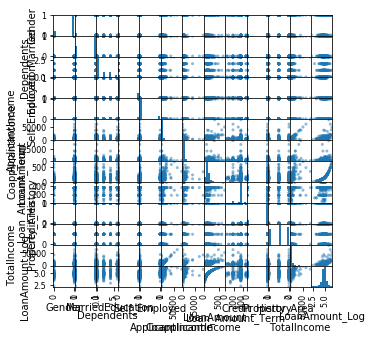

In [48]:
pd.plotting.scatter_matrix(df, figsize=(5, 5))
plt.pyplot.show()

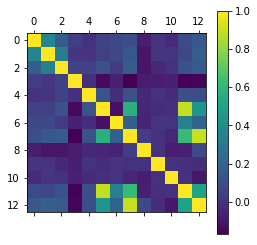

In [49]:
plt.pyplot.matshow(df.corr())
plt.pyplot.colorbar()
plt.pyplot.show()